# Emotion Recognition

**HuBERT** leverages the masked prediction loss over sequences, e.g., 
Google’s Bidirectional Encoder Representations from Transformers, or BERT, method, to represent the sequential structure of speech. HuBERT uses an offline clustering step to generate noisy labels for Masked Language Model pretraining. Concretely, HuBERT consumes masked continuous speech features to predict predetermined cluster assignments. The predictive loss is applied over only the masked regions, forcing the model to learn good high-level representations of unmasked inputs in order to infer the targets of masked ones correctly.

<img src="https://scontent-arn2-1.xx.fbcdn.net/v/t39.2365-6/199774494_858205978461255_8774541146123618096_n.jpg?_nc_cat=102&ccb=1-3&_nc_sid=ad8a9d&_nc_ohc=ijlx7hJyyDYAX9kLFAg&_nc_ht=scontent-arn2-1.xx&oh=7eed4335bf838d8372c50cae730c13a8&oe=60F2042B" alt="HuBERT" height="700" />

The official [paper](https://arxiv.org/pdf/2106.07447.pdf).

In this notebook, we will go through how to use this model to recognize the emotional aspects of speech in a language (or even as a general view using for every classification problem). Before going any further, we need to install some handy packages and define some enviroment values.

In [27]:
!nvidia-smi

Fri Oct 29 17:13:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   49C    P5    20W /  N/A |    482MiB /  5934MiB |     38%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Since the dataset is hosted on [Mega](https://mega.nz/#F!0ShVXY7C!-73kVoK05OjTPEA95UUvMw) and unable to access it directly, we upload the dataset on the G-drive to make this tutorial accessible.

In [42]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

import torchaudio
from sklearn.model_selection import train_test_split
import os
import sys
import matplotlib.pyplot as plt
import librosa.display

In [39]:
RAV = "kaggle/input/ravdess/audio_speech_actors_01-24/"
dir_list = os.listdir(RAV)
dir_list[0:5]

['Actor_08', 'Actor_15', 'Actor_19', 'Actor_21', 'Actor_01']

In [40]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

female_neutral     144
male_neutral       144
male_angry          96
male_sad            96
female_fear         96
female_angry        96
male_disgust        96
female_sad          96
male_surprise       96
female_disgust      96
male_fear           96
female_happy        96
male_happy          96
female_surprise     96
Name: labels, dtype: int64

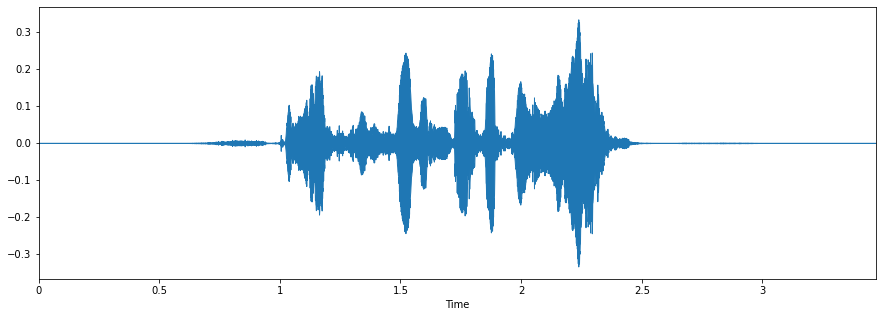

In [43]:
# Pick a fearful track
fname = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

In [44]:
RAV_df

,labels,source,path
0,male_neutral,RAVDESS,kaggle/input/ravdess/audio_speech_actors_01-24...
1,male_surprise,RAVDESS,kaggle/input/ravdess/audio_speech_actors_01-24...
2,male_surprise,RAVDESS,kaggle/input/ravdess/audio_speech_actors_01-24...
3,male_disgust,RAVDESS,kaggle/input/ravdess/audio_speech_actors_01-24...
4,male_disgust,RAVDESS,kaggle/input/ravdess/audio_speech_actors_01-24...
...,...,...,...
1435,female_surprise,RAVDESS,kaggle/input/ravdess/audio_speech_actors_01-24...
1436,female_fear,RAVDESS,kaggle/input/ravdess/audio_speech_actors_01-24...
1437,female_angry,RAVDESS,kaggle/input/ravdess/audio_speech_actors_01-24...
1438,female_surprise,RAVDESS,kaggle/input/ravdess/audio_speech_actors_01-24...


Let's explore how many labels (emotions) are in the dataset with what distribution.

In [45]:
print("Labels: ", RAV_df["labels"].unique())
print()
RAV_df.groupby("labels").count()[["path"]]

Labels:  ['male_neutral' 'male_surprise' 'male_disgust' 'male_sad' 'male_angry'
 'male_happy' 'male_fear' 'female_sad' 'female_happy' 'female_angry'
 'female_fear' 'female_surprise' 'female_neutral' 'female_disgust']



,path
labels,
female_angry,96
female_disgust,96
female_fear,96
female_happy,96
female_neutral,144
female_sad,96
female_surprise,96
male_angry,96
male_disgust,96


Let's display some random sample of the dataset and run it a couple of times to get a feeling for the audio and the emotional label.

In [46]:
import torchaudio
import librosa
import IPython.display as ipd
import numpy as np

idx = np.random.randint(0, len(RAV_df))
sample = RAV_df.iloc[idx]
path = sample["path"]
label = sample["labels"]


print(f"ID Location: {idx}")
print(f"      Label: {label}")
print()

speech, sr = torchaudio.load(path)
speech = speech[0].numpy().squeeze()
speech = librosa.resample(np.asarray(speech), sr, 16_000)
ipd.Audio(data=np.asarray(speech), autoplay=True, rate=16000)

ID Location: 1289
      Label: female_fear



For training purposes, we need to split data into train test sets; in this specific example, we break with a `20%` rate for the test set.

In [47]:
save_path = "content/data"

train_df, test_df = train_test_split(RAV_df, test_size=0.2, random_state=101, stratify=RAV_df["labels"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)


print(train_df.shape)
print(test_df.shape)

(1152, 3)
(288, 3)


## Prepare Data for Training

In [48]:
# Loading the created dataset using datasets
from datasets import load_dataset, load_metric


data_files = {
    "train": "/content/data/train.csv", 
    "validation": "/content/data/test.csv",
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

print(train_dataset)
print(eval_dataset)

AttributeError: module 'huggingface_hub.hf_api' has no attribute 'DatasetInfo'

In [50]:
# We need to specify the input and output column
input_column = "path"
output_column = "labels"

In [51]:
# we need to distinguish the unique labels in our SER dataset
label_list = train_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

NameError: name 'train_dataset' is not defined

In order to preprocess the audio into our classification model, we need to set up the relevant HuBERT scale in this case `facebook/hubert-base-ls960` by [FaceBook HuBERT-Base](https://huggingface.co/facebook/hubert-base-ls960). To handle the context representations in any audio length we use a merge strategy plan (pooling mode) to concatenate that 3D representations into 2D representations.

There are three merge strategies `mean`, `sum`, and `max`. In this example, we achieved better results on the mean approach. In the following, we need to initiate the config and the feature extractor from the Dimitris model.

In [52]:
from transformers import AutoConfig, Wav2Vec2Processor, Wav2Vec2FeatureExtractor

In [53]:
model_name_or_path = "facebook/hubert-base-ls960"
pooling_mode = "mean"

In [54]:
# config
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

NameError: name 'num_labels' is not defined

In [55]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path,)
target_sampling_rate = feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

Downloading:   0%|          | 0.00/213 [00:00<?, ?B/s]

The target sampling rate: 16000


# Preprocess Data

So far, we downloaded, loaded, and split the SER dataset into train and test sets. The instantiated our strategy configuration for using context representations in our classification problem SER. Now, we need to extract features from the audio path in context representation tensors and feed them into our classification model to determine the emotion in the speech.

Since the audio file is saved in the `.wav` format, it is easy to use **[Librosa](https://librosa.org/doc/latest/index.html)** or others, but we suppose that the format may be in the `.mp3` format in case of generality. We found that the **[Torchaudio](https://pytorch.org/audio/stable/index.html)** library works best for reading in `.mp3` data.

An audio file usually stores both its values and the sampling rate with which the speech signal was digitalized. We want to store both in the dataset and write a **map(...)** function accordingly. Also, we need to handle the string labels into integers for our specific classification task in this case, the **single-label classification** you may want to use for your **regression** or even **multi-label classification**.

In [ ]:
def speech_file_to_array_fn(path):
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech

def label_to_id(label, label_list):

    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1

    return label

def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]]
    target_list = [label_to_id(label, label_list) for label in examples[output_column]]

    result = feature_extractor(speech_list, sampling_rate=target_sampling_rate)
    result["labels"] = list(target_list)

    return result

In [ ]:
train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)
eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

In [56]:
idx = 0
print(f"Training input_values: {train_dataset[idx]['input_values']}")
# print(f"Training attention_mask: {train_dataset[idx]['attention_mask']}")
print(f"Training labels: {train_dataset[idx]['labels']} - {train_dataset[idx]['emotion']}")

NameError: name 'train_dataset' is not defined

Great, now we've successfully read all the audio files, resampled the audio files to 16kHz, and mapped each audio to the corresponding label.

## Model

Before diving into the training part, we need to build our classification model based on the merge strategy. 

In [57]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


In [59]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

# from transformers.models.wav2vec2.modeling_wav2vec2 import (
#     Wav2Vec2PreTrainedModel,
#     Wav2Vec2Model
# )
from transformers.models.hubert.modeling_hubert import (
    HubertPreTrainedModel,
    HubertModel
)


class HubertClassificationHead(nn.Module):
    """Head for hubert classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class HubertForSpeechClassification(HubertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.hubert = HubertModel(config)
        self.classifier = HubertClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.hubert.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.hubert(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


## Training

The data is processed so that we are ready to start setting up the training pipeline. We will make use of 🤗's [Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer) for which we essentially need to do the following:

- Define a data collator. In contrast to most NLP models, XLSR-Wav2Vec2 has a much larger input length than output length. *E.g.*, a sample of input length 50000 has an output length of no more than 100. Given the large input sizes, it is much more efficient to pad the training batches dynamically meaning that all training samples should only be padded to the longest sample in their batch and not the overall longest sample. Therefore, fine-tuning XLSR-Wav2Vec2 requires a special padding data collator, which we will define below

- Evaluation metric. During training, the model should be evaluated on the word error rate. We should define a `compute_metrics` function accordingly

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the test data and verify that it has indeed learned to correctly transcribe speech.

### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

Without going into too many details, in contrast to the common data collators, this data collator treats the `input_values` and `labels` differently and thus applies to separate padding functions on them (again making use of XLSR-Wav2Vec2's context manager). This is necessary because in speech input and output are of different modalities meaning that they should not be treated by the same padding function.
Analogous to the common data collators, the padding tokens in the labels with `-100` so that those tokens are **not** taken into account when computing the loss.

In [60]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch

import transformers
from transformers import Wav2Vec2FeatureExtractor


@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        feature_extractor (:class:`~transformers.Wav2Vec2FeatureExtractor`)
            The feature_extractor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    feature_extractor: Wav2Vec2FeatureExtractor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.feature_extractor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [61]:
data_collator = DataCollatorCTCWithPadding(feature_extractor=feature_extractor, padding=True)

Next, the evaluation metric is defined. There are many pre-defined metrics for classification/regression problems, but in this case, we would continue with just **Accuracy** for classification and **MSE** for regression. You can define other metrics on your own.

In [62]:
is_regression = False

In [63]:
import numpy as np
from transformers import EvalPrediction


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)

    if is_regression:
        return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
    else:
        return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

Now, we can load the pretrained checkpoint into our classification model with a pooling strategy.

In [67]:
drive_dir = "content"
!ls {drive_dir}
output_dir = os.path.join(drive_dir, "ckpts", "hubert-ser")
!ls {output_dir}

data
ls: cannot access 'content/ckpts/hubert-ser': No such file or directory


In [68]:
import os
import shutil

last_checkpoint = None
checkpoints = []
if os.path.exists(output_dir):
    for subdir in os.scandir(output_dir):
        if subdir.is_dir():
            checkpoints.append(subdir.path)
            
            
if len(checkpoints) > 0:
    checkpoints = list(sorted(checkpoints, key=lambda ckpt: ckpt.split('/')[-1].split('-')[-1], reverse=True))
    model_name_or_path = os.path.join("/content", checkpoints[0].split("/")[-1])
    last_checkpoint = model_name_or_path
    shutil.copytree(checkpoints[0], model_name_or_path)

In [69]:
print(f"model_name_or_path: {model_name_or_path}")
print(f"last_checkpoint: {last_checkpoint}")

model_name_or_path: facebook/hubert-base-ls960
last_checkpoint: None


In [70]:
model = HubertForSpeechClassification.from_pretrained(
    model_name_or_path,
    config=config,
)

NameError: name 'config' is not defined

The first component of XLSR-Wav2Vec2 consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretraining and as stated in the [paper](https://arxiv.org/pdf/2006.13979.pdf) does not need to be fine-tuned anymore. 
Thus, we can set the `requires_grad` to `False` for all parameters of the *feature extraction* part.

In [ ]:
model.freeze_feature_extractor()

In a final step, we define all parameters related to training. 
To give more explanation on some of the parameters:
- `learning_rate` and `weight_decay` were heuristically tuned until fine-tuning has become stable. Note that those parameters strongly depend on the Common Voice dataset and might be suboptimal for other speech datasets.

For more explanations on other parameters, one can take a look at the [docs](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer#trainingarguments).

**Note**: If one wants to save the trained models in his/her google drive the commented-out `output_dir` can be used instead.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    num_train_epochs=1.0,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=1e-4,
    save_total_limit=2,
    do_train=True,
    do_eval=True,
    do_predict=True
)

For future use we can create our training script, we do it in a simple way. You can add more on you own.

In [ ]:
from typing import Any, Dict, Union

import torch
from packaging import version
from torch import nn

from transformers import (
    Trainer,
    is_apex_available,
)

if is_apex_available():
    from apex import amp

if version.parse(torch.__version__) >= version.parse("1.6"):
    _is_native_amp_available = True
    from torch.cuda.amp import autocast


class CTCTrainer(Trainer):
    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
        """
        Perform a training step on a batch of inputs.

        Subclass and override to inject custom behavior.

        Args:
            model (:obj:`nn.Module`):
                The model to train.
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.

                The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
                argument :obj:`labels`. Check your model's documentation for all accepted arguments.

        Return:
            :obj:`torch.Tensor`: The tensor with training loss on this batch.
        """

        model.train()
        inputs = self._prepare_inputs(inputs)

        if self.use_amp:
            with autocast():
                loss = self.compute_loss(model, inputs)
        else:
            loss = self.compute_loss(model, inputs)

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        if self.use_amp:
            self.scaler.scale(loss).backward()
        elif self.use_apex:
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        elif self.deepspeed:
            self.deepspeed.backward(loss)
        else:
            loss.backward()

        return loss.detach()


Now, all instances can be passed to Trainer and we are ready to start training!

In [ ]:
trainer = CTCTrainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=feature_extractor,
)

### Training

Training will take between 10 and 60 minutes depending on the GPU allocated to this notebook. 

In case you want to use this google colab to fine-tune your model, you should make sure that your training doesn't stop due to inactivity. A simple hack to prevent this is to paste the following code into the console of this tab (right mouse click -> inspect -> Console tab and insert code).

```javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```

In [ ]:
if training_args.do_train:
    print(f"last_checkpoint: {last_checkpoint}")
    train_result = trainer.train(resume_from_checkpoint=last_checkpoint)
    trainer.save_model()
    feature_extractor.save_pretrained(training_args.output_dir)
    metrics = train_result.metrics
    metrics["train_samples"] = len(train_dataset)

    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)
    trainer.save_state()

last_checkpoint: None


Step,Training Loss,Validation Loss,Accuracy
10,1.640200,1.593208,0.223140
20,1.565500,1.487835,0.380165
30,1.451700,1.311041,0.404959
40,1.335400,1.469661,0.429752
50,1.373700,1.197774,0.454545
60,1.214400,1.171175,0.487603


The training loss goes down and we can see that the Acurracy on the test set also improves nicely. Because this notebook is just for demonstration purposes, we can stop here.

The resulting model of this notebook has been saved to [m3hrdadfi/hubert-base-greek-speech-emotion-recognition](https://huggingface.co/m3hrdadfi/hubert-base-greek-speech-emotion-recognition)

As a final check, let's load the model and verify that it indeed has learned to recognize the emotion in the speech.

Let's first load the pretrained checkpoint.

## Evaluation

In [ ]:
import librosa
from datasets import load_dataset, load_metric
from sklearn.metrics import classification_report
from transformers import AutoConfig, Wav2Vec2Processor, Wav2Vec2FeatureExtractor

In [ ]:
test_dataset = load_dataset("csv", data_files={"test": "/content/data/test.csv"}, delimiter="\t")["test"]
test_dataset

Using custom data configuration default-c0949ad448731ab8


Dataset csv downloaded and prepared to /content/cache/csv/default-c0949ad448731ab8/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 121
})

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [ ]:
model_name_or_path = "m3hrdadfi/hubert-base-greek-speech-emotion-recognition"
config = AutoConfig.from_pretrained(model_name_or_path)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
model = HubertForSpeechClassification.from_pretrained(model_name_or_path).to(device)

In [ ]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    speech_array = speech_array.squeeze().numpy()
    speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, feature_extractor.sampling_rate)

    batch["speech"] = speech_array
    return batch


def predict(batch):
    features = feature_extractor(batch["speech"], sampling_rate=feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)

    with torch.no_grad():
        logits = model(input_values).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

In [ ]:
test_dataset = test_dataset.map(speech_file_to_array_fn)

In [ ]:
result = test_dataset.map(predict, batched=True, batch_size=2)

In [ ]:
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names

['anger', 'disgust', 'fear', 'happiness', 'sadness']

In [ ]:
y_true = [config.label2id[name] for name in result["emotion"]]
y_pred = result["predicted"]

print(y_true[:5])
print(y_pred[:5])

[1, 4, 0, 4, 3]
[1, 4, 0, 4, 3]


In [ ]:
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

       anger       1.00      0.96      0.98        24
     disgust       0.89      1.00      0.94        24
        fear       1.00      1.00      1.00        24
   happiness       0.95      0.88      0.91        24
     sadness       1.00      1.00      1.00        25

    accuracy                           0.97       121
   macro avg       0.97      0.97      0.97       121
weighted avg       0.97      0.97      0.97       121



# Prediction

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from transformers import AutoConfig, Wav2Vec2Processor

import librosa
import IPython.display as ipd
import numpy as np
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name_or_path = "m3hrdadfi/hubert-base-greek-speech-emotion-recognition"
config = AutoConfig.from_pretrained(model_name_or_path)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
sampling_rate = feature_extractor.sampling_rate
model = HubertForSpeechClassification.from_pretrained(model_name_or_path).to(device)

In [ ]:
def speech_file_to_array_fn(path, sampling_rate):
    speech_array, _sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech


def predict(path, sampling_rate):
    speech = speech_file_to_array_fn(path, sampling_rate)
    features = feature_extractor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)

    with torch.no_grad():
        logits = model(input_values).logits

    scores = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
    outputs = [{"Label": config.id2label[i], "Score": f"{round(score * 100, 3):.1f}%"} for i, score in enumerate(scores)]
    return outputs


STYLES = """
<style>
div.display_data {
    margin: 0 auto;
    max-width: 500px;
}
table.xxx {
    margin: 50px !important;
    float: right !important;
    clear: both !important;
}
table.xxx td {
    min-width: 300px !important;
    text-align: center !important;
}
</style>
""".strip()

def prediction(df_row):
    path, label = df_row["path"], df_row["emotion"]
    df = pd.DataFrame([{"Emotion": label, "Sentence": "    "}])
    setup = {
        'border': 2,
        'show_dimensions': True,
        'justify': 'center',
        'classes': 'xxx',
        'escape': False,
    }
    ipd.display(ipd.HTML(STYLES + df.to_html(**setup) + "<br />"))
    speech, sr = torchaudio.load(path)
    speech = speech[0].numpy().squeeze()
    speech = librosa.resample(np.asarray(speech), sr, sampling_rate)
    ipd.display(ipd.Audio(data=np.asarray(speech), autoplay=True, rate=sampling_rate))

    outputs = predict(path, sampling_rate)
    r = pd.DataFrame(outputs)
    ipd.display(ipd.HTML(STYLES + r.to_html(**setup) + "<br />"))

In [ ]:
test = pd.read_csv("/content/data/test.csv", sep="\t")
test.head()

,name,path,emotion
0,d11 (4),/content/data/aesdd/disgust/d11 (4).wav,disgust
1,s10 (4),/content/data/aesdd/sadness/s10 (4).wav,sadness
2,a13 (5),/content/data/aesdd/anger/a13 (5).wav,anger
3,s05 (2),/content/data/aesdd/sadness/s05 (2).wav,sadness
4,h03 (4),/content/data/aesdd/happiness/h03 (4).wav,happiness


In [ ]:
prediction(test.iloc[0])

,Emotion,Sentence
0,disgust,


,Label,Score
0,anger,0.1%
1,disgust,98.9%
2,fear,0.2%
3,happiness,0.5%
4,sadness,0.3%


In [ ]:
prediction(test.iloc[1])

,Emotion,Sentence
0,sadness,


,Label,Score
0,anger,0.1%
1,disgust,0.3%
2,fear,0.3%
3,happiness,0.0%
4,sadness,99.3%


In [ ]:
prediction(test.iloc[2])

,Emotion,Sentence
0,anger,


,Label,Score
0,anger,98.4%
1,disgust,0.1%
2,fear,0.2%
3,happiness,1.1%
4,sadness,0.2%
